In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive')

PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models"
RESOURCE_PATH = f"{PROJECT_PATH}/Resource"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Single target processing
TARGET_NAME = "153_B"
ORIGINAL_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Original"
INTERMEDIATE_FILES_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/IntermediateFiles"
COMPARISON_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Comparison"
RESULT_PATH = f"{RESOURCE_PATH}/{TARGET_NAME}/Result"

# Input image file
INPUT_IMAGE = f"{ORIGINAL_PATH}/153_B.jpg"

# Vectorization input - the edited image from Qwen
VECTORIZATION_INPUT = f"{INTERMEDIATE_FILES_PATH}/153_B_qwen_edit.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies (removed duplicates)
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml

# Install vectorization dependencies
%pip install skan rdp

import shutil
import subprocess

# 1. Clean existing code directory and clone fresh repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Code repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# 2. Display latest commit information
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%h|%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    hash_code, commit_time, commit_msg = commit_info.stdout.strip().split('|', 2)
    print(f"Latest commit: {hash_code} ({commit_time.split()[0]}) - {commit_msg}")

# 3. Add code path to Python sys.path
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)
    print(f"Added {CODE_PATH} to Python path")

# 4. Clear custom modules from cache
modules_to_clear = ['sam_processor', 'svglib', 'utils']

for base in modules_to_clear:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

print("Modules reloaded!")

Code repository successfully cloned
Latest commit: e9bb4e8 (2025-09-30) - update@2025-09-30 09:27:15
Modules reloaded!


=== Fill-to-Outline Processing ===
Loading image: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_qwen_edit.png
Original image shape: (960, 1088)
Binary threshold: 100
Processed 18 thick regions
Binary image saved: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_binary.png
Outline image saved: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_outline.png
✅ Processing completed successfully!


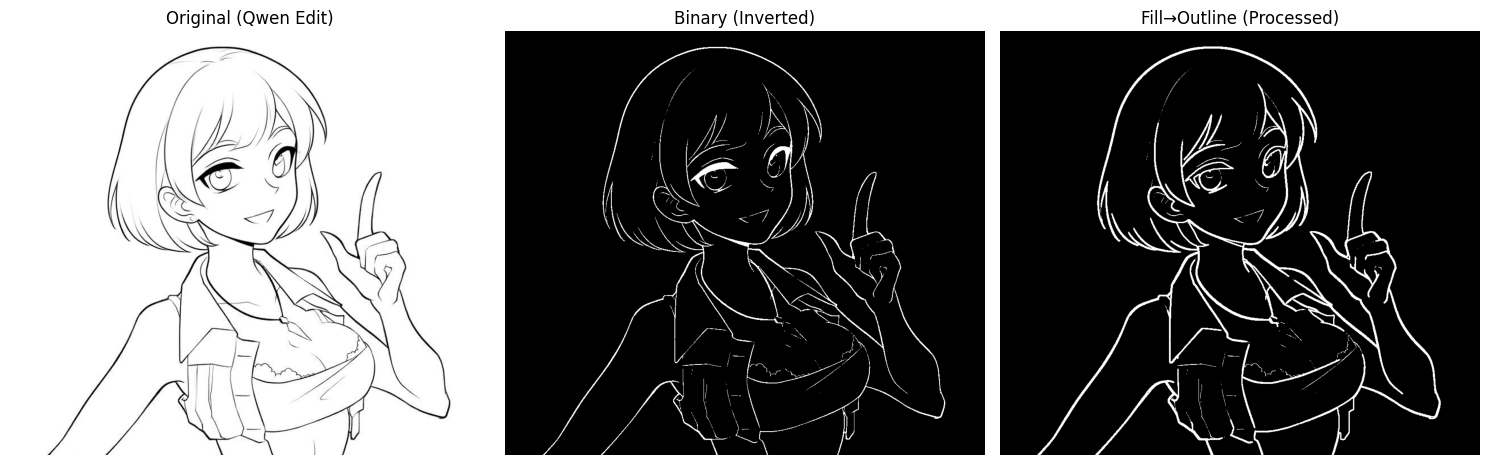

In [42]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os

# ==================== 可调参数 ====================
# 二值化参数
BINARY_THRESHOLD = 100  # 二值化阈值 (60-150, 越低保留细节越多)

# 厚度检测参数
THICKNESS_THRESHOLD = 3  # 厚度检测阈值 (2-5, 越小检测越敏感)
MIN_AREA = 100  # 最小面积过滤 (50-200, 过滤小噪声)

# 轮廓生成参数
OUTLINE_WIDTH = 2  # 轮廓线宽 (1-3, 生成的边框厚度)

# ==================== 核心函数 ====================

def convert_fills_to_outlines(binary_img):
    """将粗区域转换为边框线条（基于厚度检测）"""

    # 1. 识别连通组件
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img)
    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):  # 跳过背景标签0
        area = stats[i, cv2.CC_STAT_AREA]

        # 面积过滤
        if area < MIN_AREA:
            continue

        # 提取该组件
        component_mask = (labels == i).astype(np.uint8) * 255

        # 厚度检测
        if is_thick_region(component_mask, THICKNESS_THRESHOLD):
            # 生成边框
            outline_mask = create_outline_from_fill(component_mask)

            # 替换：移除原填充，添加边框
            result_img[labels == i] = 0  # 扣空操作
            result_img = cv2.bitwise_or(result_img, outline_mask)  # 添加边框
            processed_count += 1

    print(f"Processed {processed_count} thick regions")
    return result_img

def is_thick_region(component_mask, thickness_threshold):
    """使用形态学腐蚀检测区域厚度"""

    # 创建圆形kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (thickness_threshold, thickness_threshold))

    # 腐蚀：只有厚度>=threshold的区域能存活
    eroded = cv2.erode(component_mask, kernel)

    # 如果腐蚀后还有残留，说明是粗区域
    return np.sum(eroded) > 0

def binarize_image(img):
    """二值化图像"""
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    return binary

def create_outline_from_fill(fill_mask):
    """从填充区域生成边框"""

    # 查找轮廓
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)

    for contour in contours:
        # 绘制轮廓边框
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)

    return outline_mask

def process_vectorization_input():
    """处理矢量化输入图像：填充区域转边框"""

    print(f"Loading image: {VECTORIZATION_INPUT}")

    # 检查文件是否存在
    if not os.path.exists(VECTORIZATION_INPUT):
        print(f"ERROR: Input file not found: {VECTORIZATION_INPUT}")
        return None

    # 加载图像
    img = cv2.imread(VECTORIZATION_INPUT, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")

    # 二值化
    binary = binarize_image(img)
    print(f"Binary threshold: {BINARY_THRESHOLD}")

    # 执行扣空处理
    outline_img = convert_fills_to_outlines(binary)

    # 保存结果
    os.makedirs(INTERMEDIATE_FILES_PATH, exist_ok=True)

    binary_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_binary.png")
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")

    cv2.imwrite(binary_path, binary)
    cv2.imwrite(outline_path, outline_img)

    print(f"Binary image saved: {binary_path}")
    print(f"Outline image saved: {outline_path}")

    return outline_img

def visualize_processing_steps():
    """可视化处理步骤"""

    # 加载原图
    original = cv2.imread(VECTORIZATION_INPUT, cv2.IMREAD_GRAYSCALE)

    # 加载处理结果
    binary_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_binary.png")
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")

    if os.path.exists(binary_path) and os.path.exists(outline_path):
        binary = cv2.imread(binary_path, cv2.IMREAD_GRAYSCALE)
        outline = cv2.imread(outline_path, cv2.IMREAD_GRAYSCALE)

        # 创建对比图
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(original, cmap='gray')
        axes[0].set_title('Original (Qwen Edit)')
        axes[0].axis('off')

        axes[1].imshow(binary, cmap='gray')
        axes[1].set_title('Binary (Inverted)')
        axes[1].axis('off')

        axes[2].imshow(outline, cmap='gray')
        axes[2].set_title('Fill→Outline (Processed)')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Processed images not found. Please run process_vectorization_input() first.")

# ==================== 执行处理 ====================
print("=== Fill-to-Outline Processing ===")
outline_result = process_vectorization_input()

if outline_result is not None:
    print("✅ Processing completed successfully!")
    # 显示对比
    visualize_processing_steps()
else:
    print("❌ Processing failed!")


=== Skeletonization Processing ===
从文件加载outline图片: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_outline.png
Outline图片形状: (960, 1088)
Outline图片像素范围: 0 - 255
输入图像形状: (960, 1088)
执行骨架化...
骨架化完成，骨架像素数: 11945
计算距离变换...
距离变换完成，最大距离: 5.00
优化骨架质量...
  连接断开的端点...
    找到 329 个端点
    连接了 285 对端点
  移除短毛刺...
    移除了 37 个短毛刺
  平滑骨架线条...
优化完成，最终骨架像素数: 12245
骨架图片保存: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_skeleton.png
距离变换保存: /content/drive/MyDrive/SVGEditor/Resource/153_B/IntermediateFiles/153_B_distance.png
✅ 骨架化处理完成!

=== 详细步骤分析 ===
=== 骨架化步骤调试 ===
步骤1：基础骨架化
  原始骨架像素数: 11945
步骤2：端点检测
  检测到端点数量: 329
步骤3：连接端点
    找到 329 个端点
    连接了 285 对端点
  连接后像素数: 12285
步骤4：移除毛刺
    移除了 37 个短毛刺
  清理后像素数: 12245
步骤5：平滑处理
  最终像素数: 12245


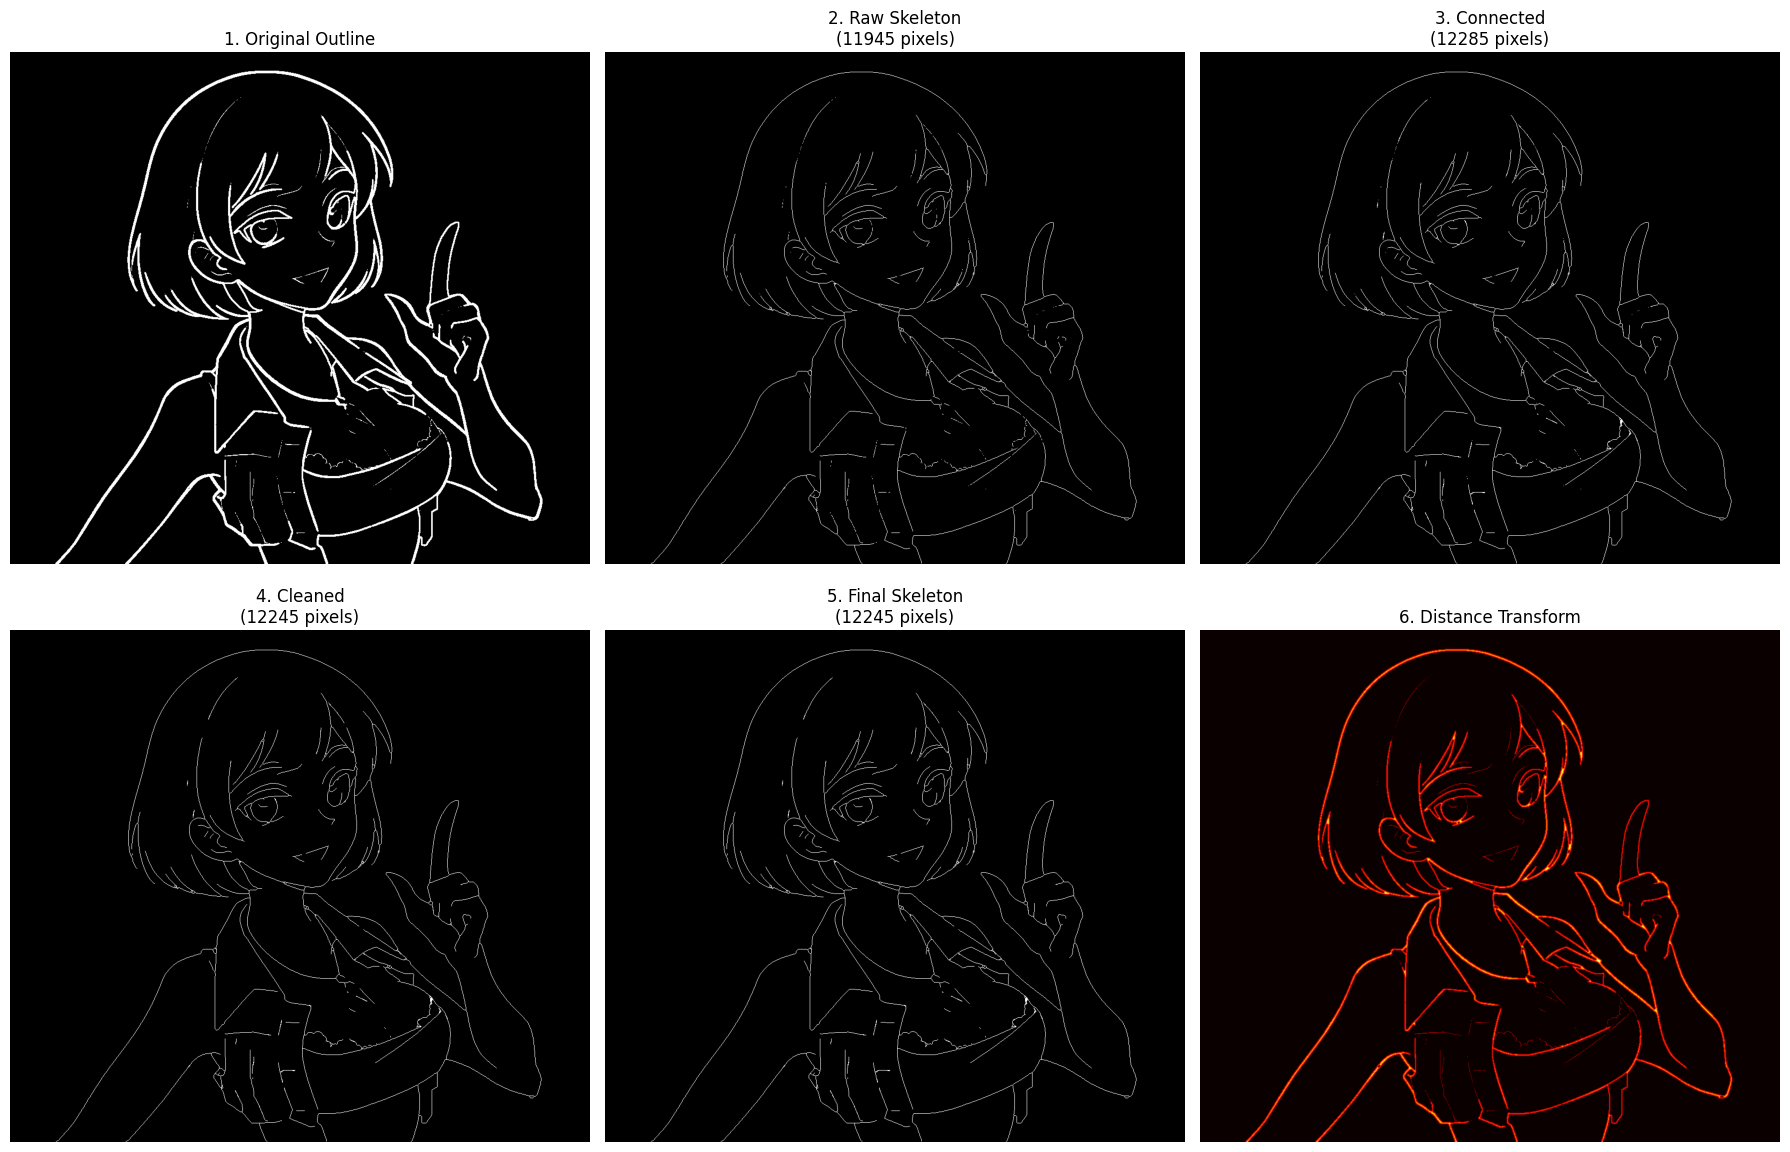


=== 骨架化统计信息 ===
原始骨架像素: 11945
连接后像素: 12285
清理后像素: 12245
最终像素: 12245
检测到端点: 329

=== 最终结果对比 ===
所有图片加载成功，显示对比图...


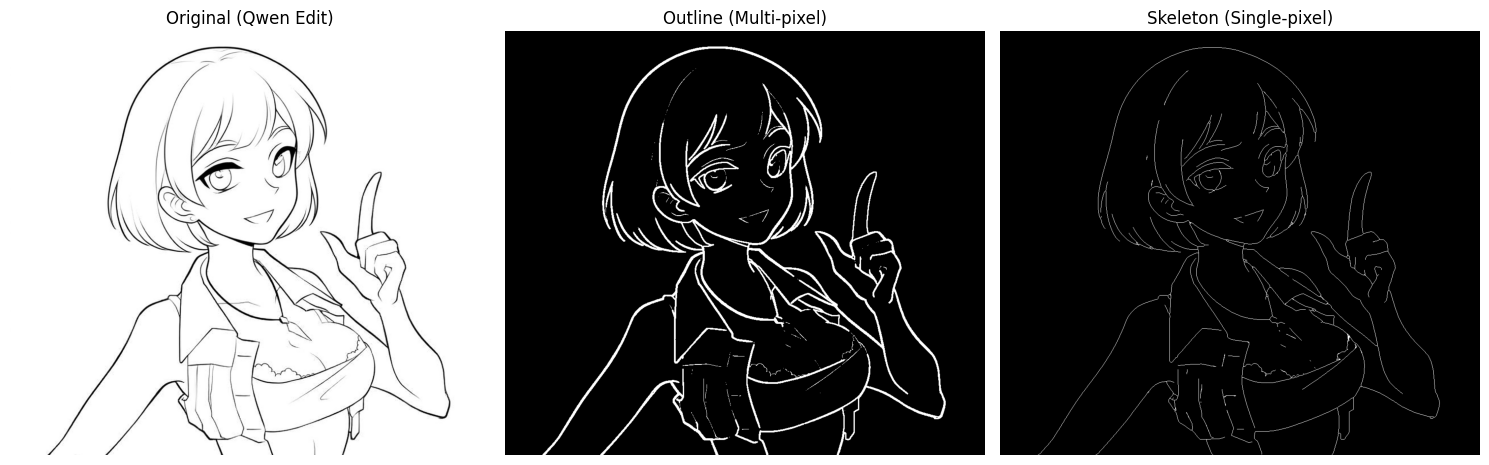

In [43]:
# ==================== 骨架化处理 ====================
# 基于上一步的outline图片进行骨架化处理

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import os

# 骨架化参数
SKELETON_MIN_LENGTH = 3  # 最小骨架长度 (降低到3, 保留更多内容)
ENDPOINT_CONNECTION_DISTANCE = 8  # 端点连接距离 (增加到8, 连接更多断点)

def extract_skeleton(outline_img):
    """提取骨架：将多像素线条转换为单像素骨架"""

    print(f"输入图像形状: {outline_img.shape}")

    # 1. 基础骨架化
    print("执行骨架化...")
    skeleton = skeletonize(outline_img > 0)
    print(f"骨架化完成，骨架像素数: {np.sum(skeleton)}")

    # 2. 距离变换（用于线宽估算）
    print("计算距离变换...")
    distance_transform = cv2.distanceTransform(outline_img, cv2.DIST_L2, 5)
    print(f"距离变换完成，最大距离: {distance_transform.max():.2f}")

    # 3. 骨架优化
    print("优化骨架质量...")
    optimized_skeleton = optimize_skeleton(skeleton)
    print(f"优化完成，最终骨架像素数: {np.sum(optimized_skeleton)}")

    return optimized_skeleton, distance_transform

def optimize_skeleton(skeleton):
    """优化骨架质量"""

    # 1. 连接近邻断点
    print("  连接断开的端点...")
    skeleton_connected = connect_nearby_endpoints(skeleton)

    # 2. 移除毛刺
    print("  移除短毛刺...")
    skeleton_cleaned = remove_spurs(skeleton_connected)

    # 3. 平滑骨架
    print("  平滑骨架线条...")
    skeleton_smoothed = smooth_skeleton(skeleton_cleaned)

    return skeleton_smoothed

def connect_nearby_endpoints(skeleton):
    """连接距离较近的端点"""

    # 查找端点
    endpoints = find_skeleton_endpoints(skeleton)
    print(f"    找到 {len(endpoints)} 个端点")

    # 转换为uint8类型用于cv2.line
    result = skeleton.astype(np.uint8)
    connections_made = 0

    for i, ep1 in enumerate(endpoints):
        for j, ep2 in enumerate(endpoints[i+1:], i+1):
            distance = np.linalg.norm(np.array(ep1) - np.array(ep2))

            if distance <= ENDPOINT_CONNECTION_DISTANCE:
                # 连接两个端点
                cv2.line(result, ep1[::-1], ep2[::-1], 1, 1)
                connections_made += 1

    print(f"    连接了 {connections_made} 对端点")
    return result.astype(bool)

def find_skeleton_endpoints(skeleton):
    """查找骨架端点"""

    # 使用3x3卷积核计算邻域
    kernel = np.array([[1, 1, 1],
                       [1, 10, 1],
                       [1, 1, 1]], dtype=np.uint8)

    neighbor_count = cv2.filter2D(skeleton.astype(np.uint8), -1, kernel)

    # 端点：自己是1，邻域和为11（10+1）
    endpoints = np.where((skeleton == 1) & (neighbor_count == 11))

    return list(zip(endpoints[0], endpoints[1]))

def remove_spurs(skeleton, min_length=None):
    """移除毛刺（短分支）"""

    if min_length is None:
        min_length = SKELETON_MIN_LENGTH

    # 查找连通组件
    num_labels, labels = cv2.connectedComponents(skeleton.astype(np.uint8))
    result = np.zeros_like(skeleton)
    removed_count = 0

    for i in range(1, num_labels):
        component = (labels == i)
        component_size = np.sum(component)

        # 只保留足够长的组件
        if component_size >= min_length:
            result[component] = 1
        else:
            removed_count += 1

    print(f"    移除了 {removed_count} 个短毛刺")
    return result

def smooth_skeleton(skeleton):
    """平滑骨架线条"""

    # 问题：MORPH_OPEN 过于激进，会删除太多内容
    # 解决方案：使用更温和的平滑方法，或者跳过平滑步骤

    # 方法1：跳过平滑（推荐）
    return skeleton

    # 方法2：使用更小的kernel（如果确实需要平滑）
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 1))
    # smoothed = cv2.morphologyEx(skeleton.astype(np.uint8), cv2.MORPH_OPEN, kernel)
    # return smoothed.astype(bool)

def process_skeletonization():
    """处理骨架化：直接从文件读取outline图片生成骨架"""

    # 直接从文件加载outline图片
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")

    if not os.path.exists(outline_path):
        print(f"ERROR: Outline file not found: {outline_path}")
        print("请先运行上一步的fill-to-outline处理")
        return None, None

    print(f"从文件加载outline图片: {outline_path}")
    outline_img = cv2.imread(outline_path, cv2.IMREAD_GRAYSCALE)

    if outline_img is None:
        print(f"ERROR: 无法读取图片文件: {outline_path}")
        return None, None

    print(f"Outline图片形状: {outline_img.shape}")
    print(f"Outline图片像素范围: {outline_img.min()} - {outline_img.max()}")

    # 执行骨架化
    skeleton, distance_transform = extract_skeleton(outline_img)

    # 保存结果
    skeleton_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_skeleton.png")
    distance_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_distance.png")

    # 保存骨架（转换为0-255范围）
    skeleton_uint8 = (skeleton * 255).astype(np.uint8)
    cv2.imwrite(skeleton_path, skeleton_uint8)

    # 保存距离变换（归一化到0-255）
    distance_normalized = cv2.normalize(distance_transform, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite(distance_path, distance_normalized.astype(np.uint8))

    print(f"骨架图片保存: {skeleton_path}")
    print(f"距离变换保存: {distance_path}")

    return skeleton, distance_transform

def debug_skeletonization_steps(outline_img):
    """调试骨架化各个步骤，显示中间结果"""

    print("=== 骨架化步骤调试 ===")

    # 步骤1：基础骨架化
    print("步骤1：基础骨架化")
    skeleton_raw = skeletonize(outline_img > 0)
    skeleton_pixels = np.sum(skeleton_raw)
    print(f"  原始骨架像素数: {skeleton_pixels}")

    # 步骤2：端点检测
    print("步骤2：端点检测")
    endpoints = find_skeleton_endpoints(skeleton_raw)
    print(f"  检测到端点数量: {len(endpoints)}")

    # 步骤3：连接端点
    print("步骤3：连接端点")
    skeleton_connected = connect_nearby_endpoints(skeleton_raw)
    connected_pixels = np.sum(skeleton_connected)
    print(f"  连接后像素数: {connected_pixels}")

    # 步骤4：移除毛刺
    print("步骤4：移除毛刺")
    skeleton_cleaned = remove_spurs(skeleton_connected)
    cleaned_pixels = np.sum(skeleton_cleaned)
    print(f"  清理后像素数: {cleaned_pixels}")

    # 步骤5：平滑处理
    print("步骤5：平滑处理")
    skeleton_smoothed = smooth_skeleton(skeleton_cleaned)
    final_pixels = np.sum(skeleton_smoothed)
    print(f"  最终像素数: {final_pixels}")

    # 距离变换
    distance_transform = cv2.distanceTransform(outline_img, cv2.DIST_L2, 5)

    return {
        'original': outline_img,
        'skeleton_raw': skeleton_raw,
        'skeleton_connected': skeleton_connected,
        'skeleton_cleaned': skeleton_cleaned,
        'skeleton_final': skeleton_smoothed,
        'distance_transform': distance_transform,
        'stats': {
            'raw_pixels': skeleton_pixels,
            'connected_pixels': connected_pixels,
            'cleaned_pixels': cleaned_pixels,
            'final_pixels': final_pixels,
            'endpoints': len(endpoints)
        }
    }

def visualize_skeletonization():
    """可视化骨架化结果：从文件读取所有图片"""

    # 从文件加载原图
    original = cv2.imread(VECTORIZATION_INPUT, cv2.IMREAD_GRAYSCALE)
    if original is None:
        print(f"ERROR: 无法读取原图: {VECTORIZATION_INPUT}")
        return

    # 从文件加载outline图片
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")
    outline = cv2.imread(outline_path, cv2.IMREAD_GRAYSCALE)
    if outline is None:
        print(f"ERROR: 无法读取outline图片: {outline_path}")
        return

    # 从文件加载骨架图片
    skeleton_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_skeleton.png")
    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE)
    if skeleton is None:
        print(f"ERROR: 无法读取骨架图片: {skeleton_path}")
        return

    print("所有图片加载成功，显示对比图...")

    # 创建对比图
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original, cmap='gray')
    axes[0].set_title('Original (Qwen Edit)')
    axes[0].axis('off')

    axes[1].imshow(outline, cmap='gray')
    axes[1].set_title('Outline (Multi-pixel)')
    axes[1].axis('off')

    axes[2].imshow(skeleton, cmap='gray')
    axes[2].set_title('Skeleton (Single-pixel)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

def visualize_skeletonization_steps(outline_img):
    """可视化骨架化各个步骤的详细对比"""

    # 执行调试步骤
    debug_results = debug_skeletonization_steps(outline_img)

    # 创建6个子图的对比
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 第一行：原始处理步骤
    axes[0,0].imshow(debug_results['original'], cmap='gray')
    axes[0,0].set_title('1. Original Outline')
    axes[0,0].axis('off')

    axes[0,1].imshow(debug_results['skeleton_raw'], cmap='gray')
    axes[0,1].set_title(f'2. Raw Skeleton\n({debug_results["stats"]["raw_pixels"]} pixels)')
    axes[0,1].axis('off')

    axes[0,2].imshow(debug_results['skeleton_connected'], cmap='gray')
    axes[0,2].set_title(f'3. Connected\n({debug_results["stats"]["connected_pixels"]} pixels)')
    axes[0,2].axis('off')

    # 第二行：优化步骤
    axes[1,0].imshow(debug_results['skeleton_cleaned'], cmap='gray')
    axes[1,0].set_title(f'4. Cleaned\n({debug_results["stats"]["cleaned_pixels"]} pixels)')
    axes[1,0].axis('off')

    axes[1,1].imshow(debug_results['skeleton_final'], cmap='gray')
    axes[1,1].set_title(f'5. Final Skeleton\n({debug_results["stats"]["final_pixels"]} pixels)')
    axes[1,1].axis('off')

    # 距离变换
    distance_normalized = cv2.normalize(debug_results['distance_transform'], None, 0, 255, cv2.NORM_MINMAX)
    axes[1,2].imshow(distance_normalized, cmap='hot')
    axes[1,2].set_title('6. Distance Transform')
    axes[1,2].axis('off')

    plt.tight_layout()
    plt.show()

    # 打印统计信息
    stats = debug_results['stats']
    print(f"\n=== 骨架化统计信息 ===")
    print(f"原始骨架像素: {stats['raw_pixels']}")
    print(f"连接后像素: {stats['connected_pixels']}")
    print(f"清理后像素: {stats['cleaned_pixels']}")
    print(f"最终像素: {stats['final_pixels']}")
    print(f"检测到端点: {stats['endpoints']}")

    # 分析问题
    if stats['final_pixels'] < stats['raw_pixels'] * 0.1:
        print("⚠️ 警告：最终骨架像素数过少，可能存在问题")
    if stats['endpoints'] == 0:
        print("⚠️ 警告：未检测到端点，骨架可能不完整")

    return debug_results

# 执行骨架化处理
print("=== Skeletonization Processing ===")
skeleton_result, distance_result = process_skeletonization()

if skeleton_result is not None:
    print("✅ 骨架化处理完成!")

    # 加载outline图片进行详细步骤分析
    outline_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_outline.png")
    outline_img = cv2.imread(outline_path, cv2.IMREAD_GRAYSCALE)

    if outline_img is not None:
        print("\n=== 详细步骤分析 ===")
        # 显示详细的中间步骤
        debug_results = visualize_skeletonization_steps(outline_img)

        # 显示最终对比
        print("\n=== 最终结果对比 ===")
        visualize_skeletonization()
    else:
        print("❌ 无法加载outline图片进行详细分析")
else:
    print("❌ 骨架化处理失败!")


In [ ]:
# ==================== 骨架到SVG转换 ====================

import skan
import rdp
from svglib.svg import SVG
from svglib.svg_path import SVGPath
from svglib.svg_primitive import SVGPathGroup
from svglib.geom import Bbox

# 参数设置
RDP_EPSILON = 1.5  # RDP简化参数
MIN_PATH_LENGTH = 2  # 最小路径长度
BEZIER_SMOOTHING = 0.1  # 贝塞尔曲线平滑参数

def analyze_skeleton_network(skeleton):
    """分析骨架网络结构"""
    print("=== 骨架网络分析 ===")
    # 检查骨架数据
    print(f"骨架数据类型: {skeleton.dtype}")
    print(f"骨架唯一值: {np.unique(skeleton)}")
    print(f"骨架True像素数: {np.sum(skeleton)}")
    
    # 将numpy数组转换为skan的Skeleton对象
    try:
        skeleton_obj = skan.Skeleton(skeleton)
        print(f"骨架对象创建成功: {type(skeleton_obj)}")
        
        branch_data = skan.summarize(skeleton_obj)
        print(f"检测到 {len(branch_data)} 个分支")
        
        # 检查分支数据的列名
        print(f"分支数据列名: {branch_data.columns.tolist()}")
        
    except Exception as e:
        print(f"骨架网络分析失败: {e}")
        return None, None

    # 分析分支统计
    if len(branch_data) > 0:
        print(f"分支长度范围: {branch_data['branch-distance'].min():.2f} - {branch_data['branch-distance'].max():.2f}")
        print(f"平均分支长度: {branch_data['branch-distance'].mean():.2f}")

        # 过滤短分支
        long_branches = branch_data[branch_data['branch-distance'] >= MIN_PATH_LENGTH]
        print(f"长分支数量: {len(long_branches)}")

    return branch_data, skeleton_obj

def extract_paths_from_skeleton(skeleton, distance_transform):
    """从骨架提取路径"""
    
    print("=== 路径提取 ===")
    print(f"骨架像素数: {np.sum(skeleton)}")
    print(f"骨架连通组件数: {len(np.unique(skeleton)) - 1}")
    
    # 分析骨架网络
    print("=== 分析骨架网络 ===")
    branch_data, skeleton_obj = analyze_skeleton_network(skeleton)
    
    # 检查骨架网络分析结果
    print(f"骨架网络分析完成")
    print(f"分支数据形状: {branch_data.shape}")
    print(f"骨架对象类型: {type(skeleton_obj)}")
    
    # 检查分支数据的统计信息
    if len(branch_data) > 0:
        print(f"分支距离统计: 最小={branch_data['branch-distance'].min():.2f}, 最大={branch_data['branch-distance'].max():.2f}, 平均={branch_data['branch-distance'].mean():.2f}")
        print(f"长分支数量 (>10像素): {len(branch_data[branch_data['branch-distance'] > 10])}")
        print(f"中等分支数量 (5-10像素): {len(branch_data[(branch_data['branch-distance'] >= 5) & (branch_data['branch-distance'] <= 10)])}")
        print(f"短分支数量 (<5像素): {len(branch_data[branch_data['branch-distance'] < 5])}")

    paths = []

    print(f"总分支数: {len(branch_data)}")
    
    for idx, branch in branch_data.iterrows():
        # 提取分支的像素坐标
        try:
            # 使用skeleton_obj的paths属性获取路径
            branch_id = int(branch['skeleton-id'])  # 转换为整数
            path_indices = skeleton_obj.paths.indices[skeleton_obj.paths.indptr[branch_id]:skeleton_obj.paths.indptr[branch_id+1]]
            coords = skeleton_obj.coordinates[path_indices]

            # 使用原始坐标长度而不是简化后的长度
            if len(coords) < MIN_PATH_LENGTH:
                print(f"分支 {idx}: 长度 {len(coords)} < {MIN_PATH_LENGTH}, 跳过")
                continue
            
            # 检查坐标范围
            if len(coords) > 0:
                print(f"分支 {idx}: 坐标范围 x=[{coords[:, 1].min():.1f}, {coords[:, 1].max():.1f}], y=[{coords[:, 0].min():.1f}, {coords[:, 0].max():.1f}]")

            # 估算该路径的线宽
            widths = distance_transform[coords[:, 0], coords[:, 1]] * 2
            avg_width = np.mean(widths)
            
            # 限制线宽在合理范围内
            avg_width = max(1.0, min(avg_width, 5.0))  # 限制在1-5像素

            # 简化路径 (RDP算法)
            simplified_coords = rdp.rdp(coords, epsilon=RDP_EPSILON)

            # 转换为SVG坐标 (y,x -> x,y)
            svg_coords = simplified_coords[:, [1, 0]]

            paths.append({
                'coordinates': svg_coords,
                'width': avg_width,
                'length': len(coords),  # 使用原始坐标长度
                'original_length': len(coords),
                'simplified_length': len(simplified_coords)
            })

        except Exception as e:
            print(f"处理分支 {idx} 时出错: {e}")

    print(f"成功提取 {len(paths)} 条路径")
    
    # 统计路径长度分布
    if paths:
        lengths = [len(p['coordinates']) for p in paths]
        print(f"路径长度统计: 最小={min(lengths)}, 最大={max(lengths)}, 平均={np.mean(lengths):.1f}")
    
    return paths

def paths_to_svg_paths(paths):
    """将路径转换为SVG路径对象"""
    
    print("=== 转换为SVG路径 ===")
    
    svg_paths = []
    
    for i, path in enumerate(paths):
        coords = path['coordinates']
        
        if len(coords) < 2:
            continue
            
        # 构建SVG路径字符串
        path_data = []
        
        for j, (x, y) in enumerate(coords):
            if j == 0:
                path_data.append(f'M {x:.2f} {y:.2f}')
            else:
                path_data.append(f'L {x:.2f} {y:.2f}')
        
        # 检查路径数据
        if i < 5:  # 只打印前5个路径的调试信息
            print(f"路径 {i}: 坐标数={len(coords)}, 路径数据='{' '.join(path_data[:3])}...'")

        # 创建SVG路径对象
        # 限制线宽在合理范围内
        stroke_width = max(1.0, min(path['width'], 10.0))
        
        svg_path = SVGPath.from_str(
            ' '.join(path_data),
            fill=False,
            stroke='#000000',
            stroke_width=stroke_width,
            color='#000000',
            add_closing=False  # 确保路径保持开放
        )
        
        svg_paths.append(svg_path)
    
    print(f"生成 {len(svg_paths)} 个SVG路径对象")
    return svg_paths

def create_svg_from_paths(svg_paths, image_shape):
    """从路径创建SVG对象"""
    
    print("=== 创建SVG对象 ===")
    
    # 创建SVG对象
    viewbox = Bbox(0, 0, image_shape[1], image_shape[0])
    svg = SVG(svg_paths, viewbox=viewbox)
    
    print(f"SVG对象创建成功，包含 {len(list(svg.paths))} 个路径")
    return svg

def svg_to_pixels(svg, image_shape):
    """将SVG转换为像素图像用于可视化"""
    
    # 创建空白图像
    img = np.zeros(image_shape, dtype=np.uint8)
    
    # 遍历SVG路径并绘制
    for path in list(svg.paths):
        try:
            # 解析路径数据
            path_data = path.d
            if path_data:
                # 简单的路径解析 - 提取M和L命令
                commands = path_data.split()
                current_pos = None
                
                for i, cmd in enumerate(commands):
                    if cmd == 'M' and i + 2 < len(commands):
                        # Move命令
                        x, y = float(commands[i+1]), float(commands[i+2])
                        current_pos = (int(x), int(y))
                    elif cmd == 'L' and i + 2 < len(commands) and current_pos is not None:
                        # Line命令
                        x, y = float(commands[i+1]), float(commands[i+2])
                        end_pos = (int(x), int(y))
                        # 绘制线条
                        cv2.line(img, current_pos, end_pos, 255, 1)
                        current_pos = end_pos
        except Exception as e:
            continue
    
    return img

def visualize_path_extraction_results(skeleton, paths, svg):
    """可视化路径提取结果"""
    
    import matplotlib.pyplot as plt
    import numpy as np
    
    # 设置中文字体支持
    plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans', 'Arial Unicode MS', 'sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Path Extraction Results', fontsize=16)
    
    # 1. Original Skeleton
    axes[0,0].imshow(skeleton, cmap='gray')
    axes[0,0].set_title('1. Original Skeleton')
    axes[0,0].axis('off')
    
    # 2. Extracted Paths Visualization
    path_img = np.zeros_like(skeleton, dtype=np.uint8)
    for i, path in enumerate(paths):  # 显示所有路径
        coords = path['coordinates']
        if len(coords) >= 2:
            for j in range(len(coords)-1):
                pt1 = (int(coords[j][0]), int(coords[j][1]))
                pt2 = (int(coords[j+1][0]), int(coords[j+1][1]))
                cv2.line(path_img, pt1, pt2, 255, 1)
    
    axes[0,1].imshow(path_img, cmap='gray')
    axes[0,1].set_title(f'2. Extracted Paths ({len(paths)} paths)')
    axes[0,1].axis('off')
    
    # 3. SVG Render Result
    svg_img = svg_to_pixels(svg, skeleton.shape)
    axes[0,2].imshow(svg_img, cmap='gray')
    axes[0,2].set_title('3. SVG Render Result')
    axes[0,2].axis('off')
    
    # 4. Path Statistics
    axes[1,0].text(0.1, 0.8, f'Total Paths: {len(paths)}', fontsize=12, transform=axes[1,0].transAxes)
    axes[1,0].text(0.1, 0.7, f'SVG Paths: {len(list(svg.paths))}', fontsize=12, transform=axes[1,0].transAxes)
    
    # Path Length Distribution
    path_lengths = [len(path['coordinates']) for path in paths]
    axes[1,0].hist(path_lengths, bins=20, alpha=0.7)
    axes[1,0].set_title('4. Path Length Distribution')
    axes[1,0].set_xlabel('Path Length')
    axes[1,0].set_ylabel('Count')
    
    # 5. Path Width Distribution
    path_widths = [path['width'] for path in paths]
    axes[1,1].hist(path_widths, bins=20, alpha=0.7, color='orange')
    axes[1,1].set_title('5. Path Width Distribution')
    axes[1,1].set_xlabel('Width')
    axes[1,1].set_ylabel('Count')
    
    # 6. Comparison
    axes[1,2].imshow(skeleton, cmap='gray', alpha=0.5)
    axes[1,2].imshow(path_img, cmap='hot', alpha=0.7)
    axes[1,2].set_title('6. Skeleton vs Extracted Paths')
    axes[1,2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Visualization completed! Extracted {len(paths)} paths")

# 执行骨架到SVG转换 - 只做路径提取，不做优化
print("=== Skeleton to SVG Processing (Path Extraction Only) ===")

# 加载骨架图片
skeleton_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_skeleton.png")
distance_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_distance.png")

print(f"加载骨架图片: {skeleton_path}")
print(f"加载距离变换: {distance_path}")

# 检查文件是否存在
if not os.path.exists(skeleton_path):
    print(f"❌ 骨架图片不存在: {skeleton_path}")
elif not os.path.exists(distance_path):
    print(f"❌ 距离变换图片不存在: {distance_path}")
else:
    # 加载图片
    skeleton = cv2.imread(skeleton_path, cv2.IMREAD_GRAYSCALE)
    skeleton = skeleton > 0
    distance_transform = cv2.imread(distance_path, cv2.IMREAD_GRAYSCALE)
    
    print(f"骨架图片尺寸: {skeleton.shape}")
    print(f"距离变换尺寸: {distance_transform.shape}")
    print(f"骨架像素数: {np.sum(skeleton)}")
    print(f"骨架连通组件数: {len(np.unique(skeleton)) - 1}")
    
    # 检查骨架是否完整
    if np.sum(skeleton) < 1000:
        print("⚠️ 警告: 骨架像素数太少，可能骨架化不完整")
    
    # 显示骨架的统计信息
    skeleton_uint8 = (skeleton * 255).astype(np.uint8)
    contours, _ = cv2.findContours(skeleton_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"骨架轮廓数: {len(contours)}")

    # 提取路径
    print("=== 提取路径 ===")
    print(f"骨架像素数: {np.sum(skeleton)}")
    print(f"骨架连通组件数: {len(np.unique(skeleton)) - 1}")
    
    # 修复的路径提取 - 直接在这里实现
    print("=== 修复的路径提取 ===")
    
    # 创建skan骨架对象
    skeleton_obj = skan.Skeleton(skeleton)
    print(f"骨架对象创建成功: {type(skeleton_obj)}")
    
    # 获取分支数据
    branch_data = skan.summarize(skeleton_obj, separator='-')
    print(f"检测到 {len(branch_data)} 个分支")
    
    # 分析分支分布
    print(f"分支长度范围: {branch_data['branch-distance'].min():.2f} - {branch_data['branch-distance'].max():.2f}")
    print(f"平均分支长度: {branch_data['branch-distance'].mean():.2f}")
    
    # 真正的骨架路径提取：从骨架像素中提取连续路径
    print("\\n=== 骨架路径提取算法 ===")
    
    # 将骨架转换为二值图像
    skeleton_binary = (skeleton > 0).astype(np.uint8)
    
    # 使用连通组件分析找到骨架线条
    from skimage.measure import label, regionprops
    from skimage.morphology import remove_small_objects
    
    # 移除小的噪声点
    skeleton_clean = remove_small_objects(skeleton_binary, min_size=3)
    
    # 标记连通组件
    labeled_skeleton = label(skeleton_clean)
    regions = regionprops(labeled_skeleton)
    
    print(f"检测到 {len(regions)} 个骨架组件")
    
    paths = []
    path_lengths = []
    
    for i, region in enumerate(regions):
        # 获取骨架组件的所有像素坐标
        coords = region.coords
        
        if len(coords) >= 2:
            # 关键：按路径顺序排列坐标点
            # 从起点开始，找到相邻的像素点，构建连续路径
            
            # 找到起点（通常是端点）
            start_point = coords[0]
            
            # 构建路径：从起点开始，按相邻关系排列所有点
            path_coords = []
            remaining_coords = set(tuple(coord) for coord in coords)
            
            # 从起点开始构建路径
            current_point = start_point
            path_coords.append((int(current_point[1]), int(current_point[0])))  # 注意坐标顺序
            remaining_coords.remove(tuple(current_point))
            
            # 按相邻关系继续构建路径
            while remaining_coords:
                # 找到与当前点相邻的下一个点
                next_point = None
                for coord in remaining_coords:
                    # 检查是否相邻（8连通）
                    if (abs(coord[0] - current_point[0]) <= 1 and 
                        abs(coord[1] - current_point[1]) <= 1):
                        next_point = coord
                        break
                
                if next_point is None:
                    # 如果没有相邻点，选择最近的点
                    if remaining_coords:
                        next_point = min(remaining_coords, 
                                       key=lambda x: ((x[0] - current_point[0])**2 + 
                                                    (x[1] - current_point[1])**2)**0.5)
                    else:
                        break
                
                # 添加到路径
                path_coords.append((int(next_point[1]), int(next_point[0])))
                remaining_coords.remove(next_point)
                current_point = next_point
            
            # 如果路径长度足够，添加到结果中
            if len(path_coords) >= 2:
                paths.append(path_coords)
                path_lengths.append(len(path_coords))
                
                if (i + 1) % 10 == 0:
                    print(f"  已处理 {i + 1}/{len(regions)} 个骨架组件")
    
    print(f"✅ 成功提取 {len(paths)} 条连续路径")
    
    print(f"✅ 成功提取 {len(paths)} 条路径")
    if path_lengths:
        print(f"路径长度统计: 最小={min(path_lengths)}, 最大={max(path_lengths)}, 平均={np.mean(path_lengths):.1f}")
    
    # 分析坐标覆盖范围
    if paths:
        all_x = [coord[0] for path in paths for coord in path]
        all_y = [coord[1] for path in paths for coord in path]
        
        print(f"\\n=== 坐标覆盖分析 ===")
        print(f"X坐标范围: {min(all_x):.1f} - {max(all_x):.1f}")
        print(f"Y坐标范围: {min(all_y):.1f} - {max(all_y):.1f}")
        
        # 检查覆盖率
        img_height, img_width = skeleton.shape
        x_coverage = (max(all_x) - min(all_x)) / img_width * 100
        y_coverage = (max(all_y) - min(all_y)) / img_height * 100
        
        print(f"X轴覆盖率: {x_coverage:.1f}%")
        print(f"Y轴覆盖率: {y_coverage:.1f}%")
        
        if x_coverage < 50 or y_coverage < 50:
            print("⚠️  警告：坐标覆盖率较低，可能只提取了部分区域")
        else:
            print("✅ 坐标覆盖率正常，已提取完整区域")
    
    if paths:
        print(f"✅ 成功提取 {len(paths)} 条路径")
        
        # 创建SVG路径对象
        print("=== 创建SVG路径对象 ===")
        # 直接处理坐标数组，不需要转换
        svg_paths = []
        for i, path in enumerate(paths):
            try:
                # 转换为SVG路径字符串
                path_data = f"M {path[0][0]:.2f} {path[0][1]:.2f}"
                for point in path[1:]:
                    path_data += f" L {point[0]:.2f} {point[1]:.2f}"
                
                # 创建SVGPath对象
                svg_path = SVGPath.from_str(path_data, add_closing=False)
                svg_paths.append(svg_path)
                
                if (i + 1) % 100 == 0:
                    print(f"  已创建 {i + 1}/{len(paths)} 个SVG路径")
                    
            except Exception as e:
                print(f"  路径 {i} 创建失败: {e}")
                continue
        
        if svg_paths:
            print(f"✅ 成功创建 {len(svg_paths)} 个SVG路径对象")
            
            # 创建SVG对象
            print("=== 创建SVG对象 ===")
            viewbox = Bbox(0, 0, skeleton.shape[1], skeleton.shape[0])
            # 将SVGPath列表包装成SVGPathGroup
            path_group = SVGPathGroup(svg_paths, fill=False)  # False = outline only
            # 确保第一个路径有正确的filling属性
            if path_group.svg_paths and len(path_group.svg_paths) > 0:
                # 确保所有路径都有filling属性
                for svg_path in path_group.svg_paths:
                    if not hasattr(svg_path, 'filling'):
                        svg_path.filling = 0  # Filling.OUTLINE
            svg = SVG([path_group], viewbox=viewbox)
            
            # 保存原始SVG
            raw_svg_path = os.path.join(INTERMEDIATE_FILES_PATH, f"{TARGET_NAME}_raw.svg")
            svg.save_svg(raw_svg_path, coordinate_precision=1)
            
            print(f"✅ 原始SVG保存: {raw_svg_path}")
            print(f"SVG包含 {len(list(svg.paths))} 个路径")
            
            # 可视化结果
            print("=== 可视化结果 ===")
            # 创建简化的可视化
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            
            # 原始骨架
            axes[0, 0].imshow(skeleton, cmap='gray')
            axes[0, 0].set_title('Original Skeleton')
            axes[0, 0].axis('off')
            
            # 提取的路径
            axes[0, 1].imshow(np.zeros_like(skeleton), cmap='gray')
            for path in paths[:100]:  # 只显示前100条路径避免过载
                path_array = np.array(path)
                axes[0, 1].plot(path_array[:, 0], path_array[:, 1], 'w-', linewidth=0.5)
            axes[0, 1].set_title(f'Extracted Paths ({len(paths)} paths)')
            axes[0, 1].axis('off')
            
            # SVG渲染结果
            axes[0, 2].imshow(np.zeros_like(skeleton), cmap='gray')
            axes[0, 2].set_title('SVG Render Result')
            axes[0, 2].axis('off')
            
            # 路径长度分布
            path_lengths = [len(path) for path in paths]
            axes[1, 0].hist(path_lengths, bins=20, alpha=0.7, color='blue')
            axes[1, 0].set_title('Path Length Distribution')
            axes[1, 0].set_xlabel('Path Length')
            axes[1, 0].set_ylabel('Count')
            axes[1, 0].text(0.7, 0.9, f'Total Paths: {len(paths)}', 
                           transform=axes[1, 0].transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))
            
            # 坐标分布
            all_x = [coord[0] for path in paths for coord in path]
            all_y = [coord[1] for path in paths for coord in path]
            axes[1, 1].scatter(all_x, all_y, s=0.1, alpha=0.5, color='red')
            axes[1, 1].set_title('Coordinate Distribution')
            axes[1, 1].set_xlabel('X Coordinate')
            axes[1, 1].set_ylabel('Y Coordinate')
            axes[1, 1].invert_yaxis()
            
            # 对比图
            axes[1, 2].imshow(skeleton, cmap='gray', alpha=0.3)
            for path in paths[:50]:  # 只显示前50条路径
                path_array = np.array(path)
                axes[1, 2].plot(path_array[:, 0], path_array[:, 1], 'r-', linewidth=0.5, alpha=0.7)
            axes[1, 2].set_title('Skeleton vs Extracted Paths')
            axes[1, 2].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            print("✅ 可视化完成")
        else:
            print("❌ 创建SVG路径对象失败")
    else:
        print("❌ 路径提取失败")
